# Semester 4 Coding Portfolio Part 1: Regularisation for Regression Models

This notebook covers the following topics:
 - Ridge Regression Estimation & Inference
 - Ridge Regression vs Linear Regression for Prediction

This notebook is expected to take around 20 hours to complete:
 - 4 hours for the formative part
 - 6 hours of self-study on the topics covered by this notebook
 - 10 hours for the summative part of this notebook

Like all notebooks in this portfolio, it is split into two sections:
 - Formative 
 - Summative

<b>Formative section</b><br>
Simply complete the given functions! You may ask for help from fellow students and TAs on this section, and solutions might be provided later on.

<b>Summative section</b><br>
In this section, you are asked to do original work with little guidance, based on the skills you learned in the formative part (as well as lectures and workshops).
This section is graded not just on passing automated tests, but also on quality, originality, and effort (see assessment criteria in the assignment description).

In [279]:
# TODO: Please enter your student number here
STUDENT_NUMBER = 14806762

# Formative Section
Please do not add additional cells to this section, and do not delete given code. Simply fill out the code or answer questions in the given cells.

### Part 1: Ridge Regression Estimation & Inference

The global terrorism dataset contains a large number of covariates of terrorist attacks. The level of analysis is the attack, and this varies over time and geographies.<br>
If we wish to learn about the specific relationship between some small number of covariates and the outcome, in this case the number of individuals we can expect to die in a terrorist attack, then a traditional linear regression approach is reasonably well suited.<br>
However, many covariates of interest experience relatively severe multicollinearity in the dataset.<br>
Moreover, we don't have a great idea about which covariates actually matter (the data generating process) before we begin the study.<br>
Finally, if our interest is in prediction, we may wish to *penalise* the complexity of our model in order to improve out-of-sample fit.

In [280]:
# Load libraries 
import numpy as np
# By default, NumPy prints very large or very small numbers in scientific notation.
# The following settings disable scientific notation and set the display precision.
np.set_printoptions(suppress=True)
np.set_printoptions(precision=6)  # show 6 digits after the decimal point

import pandas as pd
# Adjust Pandas display options so that all columns are shown and numbers are nicely formatted.
pd.set_option('display.max_columns', None)   # show all columns
pd.set_option('display.width', 1000)           # set table width to avoid line breaks
pd.set_option('display.float_format', lambda x: f'{x:.4f}')  # show floats with 4 decimal places

import matplotlib.pyplot as plt
# Ensure Pandas shows all columns (reiterating display option for safety)
pd.set_option("display.max_columns", None)

In [281]:
# Load the cleaned Global Terrorism Dataset from a CSV file.
data_path = "sem4_portfolio_1_data.csv"
df = pd.read_csv(data_path)

In [282]:
# 1. Convert the 'date' column to datetime objects so we can work with dates.
df['date'] = pd.to_datetime(df['date'], errors='coerce')

# 2. Extract the year from the 'date' column and store it in a new column called 'year'.
df['year'] = df['date'].dt.year

# 3. Convert the 'year' column to a categorical variable. 
# This is useful if you want to treat the year as a factor rather than a continuous variable.
df['year'] = df['year'].astype('category')

In [283]:
# Convert several categorical columns into dummy/indicator variables (one-hot encoding).
cat_cols = ['country', 'region', 'year', 'terrorist.org']
df_dummies = pd.get_dummies(df, columns=cat_cols, drop_first=False)

In [284]:
# These lists define which columns to use as features (X) and which as the response (Y).

# "Goal" columns: numeric/binary indicators about different objectives.
goal_cols = [
    'goal.pol.econ.rel', 
    'goal.coerce.intim.pub', 
    'goal.out.hum.law'
]

# Additional numeric/binary columns from the dataset.
additional_cols = [
    'attack.24hours.plus', 
    'unaffiliated.lone.attacker', 
    'suicide', 
    'multiple.attacks', 
    'nperps'
]

# Attack and weapon types: assume these columns exist and start with the specified prefixes.
attack_weapon_cols = [
    col for col in df.columns 
    if col.startswith('attack.type_') or col.startswith('weapon.type_')
]

# Dummy columns: these are created from the categorical variables.
dummy_cols = [
    col for col in df_dummies.columns 
    if col.startswith('country_') 
       or col.startswith('region_') 
       or col.startswith('year_') 
       or col.startswith('terrorist.org_')
]

# Combine all the features into one master list.
# NOTICE: I'm leaving all the coefficients in, as the dummy trap gets solved by the penalised regression
X_cols = goal_cols + additional_cols + attack_weapon_cols + dummy_cols

# The outcome (response) variable is 'nkill' (number killed).
Y_cols = ['nkill']

# Create a combined list of columns that includes the response and the features.
YX_cols = Y_cols + X_cols

# Subset the dataframe to include only these columns.
YX = df_dummies[YX_cols]

# Remove rows that contain any missing values.
YX_nona = YX.dropna()

# For simplicity and speed, take a random subsample of 1000 observations.
YX_nona = YX_nona.sample(n=1000, random_state=42)

In [285]:
# Zero variance columns (constant columns) do not provide useful information in regression.
variances = YX_nona.var(axis=0)  # Calculate variance for each column.
kept_columns = (variances != 0)   # Create a mask that is True for columns with non-zero variance.

# Keep only the columns with non-zero variance.
YX_nona_variable = YX_nona.loc[:, kept_columns]

# Update our feature list to include only those columns that were kept.
X_cols = [col for col in X_cols if kept_columns.get(col, False)]

In [286]:
# Split Data into Features (X) and Response (Y)
X = YX_nona_variable[X_cols]
Y = YX_nona_variable[Y_cols]

# To help with normality, transform the response by taking the log.
# Adding 1 ensures that we do not take the log of 0.
log_Y = np.log(Y + 1)

In [287]:
# Standardisation (z-scoring) centers the data and scales it to unit variance,
# which is important when using regularization (like Ridge regression).
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [288]:
# Ridge regression is used to prevent overfitting when predictors are highly correlated.
# It adds a penalty (alpha) to the size of the coefficients.
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.utils import resample

# Use cross-validation to choose the optimal regularization parameter (alpha).
# We test a wide range of candidate alpha values on a logarithmic scale.
alphas = np.logspace(-5, 5, 1000)

# TODO 1: RidgeCV Setup
# Create a RidgeCV model with specified alphas, fit_intercept=True, and negative MSE scoring
# Hint: Use RidgeCV from sklearn.linear_model
# Hint: Remember to fit it to X_scaled and log_Y
ridge_cv = RidgeCV(alphas=alphas, fit_intercept=True, scoring='neg_mean_squared_error')
ridge_cv.fit(X_scaled, log_Y)

optimal_alpha = ridge_cv.alpha_  # Optimal alpha determined by cross-validation.
print(f"Optimal alpha found via cross-validation: {optimal_alpha:.4f}")


Optimal alpha found via cross-validation: 720.8715


In [289]:
# TODO 2: Fit Ridge Model
# Create and fit a Ridge regression model with the optimal alpha previously found and fit_intercept=True
# Hint: Use the Ridge class with the found alpha
# Hint: Remember to fit the model!
ridge_model = Ridge(alpha=optimal_alpha, fit_intercept=True).fit(X_scaled, log_Y)

# Combine the intercept and coefficients into one array for later reference.
beta_hat = np.concatenate((ridge_model.intercept_.ravel(), ridge_model.coef_.ravel()))

# Create a list of names for the coefficients, starting with the intercept.
beta_names = ['(intercept)'] + X_cols

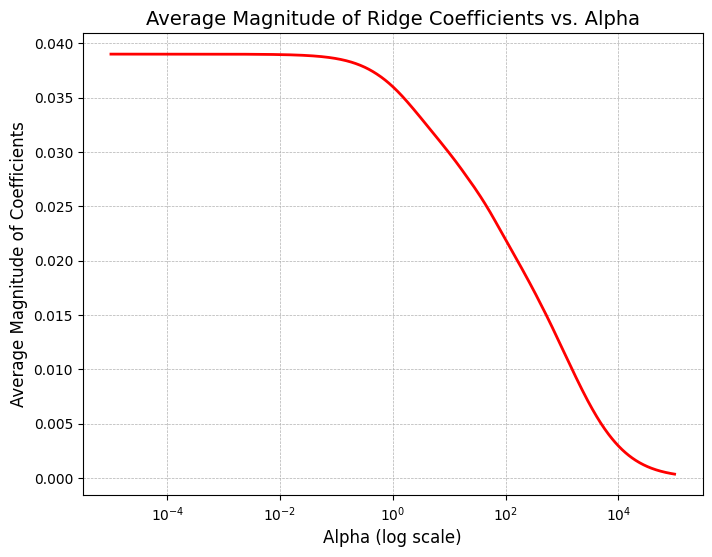

In [290]:
# Here I want to demonstrate the effect of the penalty parameter alpha on the average size of regression coefficients

# List to store the average magnitude of coefficients (betas) for each alpha
avg_coef_magnitudes = []

# Loop over each alpha value
for alpha in alphas:
    # Initialize the Ridge regression model with the current alpha
    ridge = Ridge(alpha=alpha, fit_intercept=True)
    # Fit the model on the standardized features and log-transformed response
    ridge.fit(X_scaled, log_Y)
    
    # Extract the coefficients (exclude the intercept)
    coefs = ridge.coef_.ravel()
    
    # Compute the average magnitude (absolute value) of these coefficients
    avg_magnitude = np.mean(np.abs(coefs))
    avg_coef_magnitudes.append(avg_magnitude)

# Create the plot
plt.figure(figsize=(8, 6))
plt.plot(alphas, avg_coef_magnitudes, color='red', lw=2)
plt.xscale('log')  # Use a logarithmic scale for alpha values
plt.xlabel('Alpha (log scale)', fontsize=12)
plt.ylabel('Average Magnitude of Coefficients', fontsize=12)
plt.title('Average Magnitude of Ridge Coefficients vs. Alpha', fontsize=14)
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.show(block=False)

In [291]:
# Bootstrap resampling helps us estimate the uncertainty (variability) of our coefficients.
# We repeatedly resample the data and refit the model to obtain a distribution of coefficient estimates.
n_bootstraps = 1000  # Number of bootstrap samples.
# Initialize an array to store coefficients from each bootstrap iteration.
bootstrap_coefs = np.zeros((n_bootstraps, len(X_cols) + 1))  # +1 for the intercept.

# TODO 3: Bootstrap Implementation
# Implement the bootstrap resampling loop
# Hint: Use resample() from sklearn.utils
# Hint: For each iteration out of n_bootstraps:
# 1. Create bootstrap sample
# 2. Fit Ridge model with optimal alpha
# 3. Store coefficients (use bootstrap_coefs np.array variable for this)

#. Your solution here ...
for i in range(n_bootstraps):
    # Resample the data (with replacement) to create a new bootstrap sample.
    X_scaled_boot, log_Y_boot = resample(X_scaled, log_Y)
    # Fit the Ridge regression on this bootstrap sample using the optimal alpha.
    model_boot = Ridge(alpha=optimal_alpha, fit_intercept=True)
    model_boot.fit(X_scaled_boot, log_Y_boot)
    # Store the intercept and coefficients from the bootstrap model.
    bootstrap_coefs[i, :] = np.concatenate((model_boot.intercept_.ravel(), model_boot.coef_.ravel()))



In [292]:

# TODO 4: Confidence Intervals, probabilities and standard deviation errors

# Calculate the standard errors of the coefficients from the bootstrap samples.
bootstrap_std_errors = bootstrap_coefs.std(axis=0)

# Calculate the 95% confidence intervals (using the 2.5th and 97.5th percentiles), and the median value.
# Hint: Use np.percentile for CIs (2.5th and 97.5th percentiles)
ci_lower = np.percentile(bootstrap_coefs, 2.5, axis=0)
ci_upper = np.percentile(bootstrap_coefs, 97.5, axis=0)
median   = np.percentile(bootstrap_coefs, 50, axis=0)

# Compute the probability that each coefficient is greater than 0.
# This is the proportion of bootstrap samples for which the coefficient is positive.
# Hint: prob_positive is the mean of (bootstrap_coefs > 0)
prob_positive = np.mean(bootstrap_coefs > 0, axis=0)

# Create a summary DataFrame with the bootstrap results.
summary_df = pd.DataFrame({
    "Coefficient": beta_names,
    "Median": median,
    "95% CI Lower": ci_lower,
    "95% CI Upper": ci_upper,
    "Bootstrap Std Error": bootstrap_std_errors,
    "Pr(>0)": prob_positive
})

print("\nSummary Table:")
print(summary_df.to_string(index=False))


Summary Table:
                                                                            Coefficient  Median  95% CI Lower  95% CI Upper  Bootstrap Std Error  Pr(>0)
                                                                            (intercept)  0.8916        0.8454        0.9377               0.0235  1.0000
                                                                      goal.pol.econ.rel  0.0169        0.0044        0.0295               0.0066  0.9960
                                                                  goal.coerce.intim.pub -0.0001       -0.0169        0.0160               0.0086  0.4910
                                                                       goal.out.hum.law -0.0231       -0.0494        0.0020               0.0137  0.0440
                                                                    attack.24hours.plus -0.0144       -0.0368        0.0079               0.0113  0.1050
                                                             unaff

In [293]:
# Function to Plot Bootstrap Distribution
def plot_bootstrap(bootstrap_coefs, beta_names=None, selected_vars=None, point_est='median'):
    """
    Plot bootstrap distributions for selected parameters, computing summary statistics
    directly from the bootstrap simulations.
    
    Parameters:
      bootstrap_coefs : ndarray
          Array of bootstrap simulation results (shape: n_bootstraps x n_parameters).
      beta_names : list of str, optional
          Names of the parameters. If not provided, default names ('Param0', 'Param1', ...) are used.
      selected_vars : list, optional
          List of variables to plot. Can be provided as indices (int) or as names (str).
          If None, the function plots all parameters.
      point_est : str, optional
          Method for computing the point estimate from bootstrap samples. Options are
          'mean' or 'median' (default is 'median').
    
    The function computes:
      - A point estimate (mean or median) for each parameter,
      - 95% confidence intervals (2.5th and 97.5th percentiles),
      - The probability that the coefficient is > 0.
    
    For each selected parameter, it plots:
      - A histogram of the bootstrap coefficients,
      - A dashed vertical line at the point estimate,
      - A solid vertical line at 0,
      - A legend showing the point estimate, confidence intervals, and Pr(β > 0).
    """
    # Determine the total number of parameters.
    n_params = bootstrap_coefs.shape[1]
    # Create default parameter names if none are provided.
    if beta_names is None:
        beta_names = [f"Param{i}" for i in range(n_params)]

    # TODO 5: Plotting Function Implementation
    # In the plot_bootstrap function, implement:
    # 1. Point estimate calculation (mean/median)
    # 2. Confidence interval calculation
    # 3. Probability positive calculation
    
    # Compute the point estimate based on the user's choice (mean or median).
    if point_est == 'mean':
        est = np.mean(bootstrap_coefs, axis=0)
    elif point_est == 'median':
        est = np.median(bootstrap_coefs, axis=0)
    else:
        raise ValueError("point_est must be either 'mean' or 'median'")
    
    # Calculate the 95% confidence intervals and the probability that coefficients are > 0.
    ci_lower = np.percentile(bootstrap_coefs, 2.5, axis=0)
    ci_upper = np.percentile(bootstrap_coefs, 97.5, axis=0)
    prob_positive = np.mean(bootstrap_coefs > 0, axis=0)
    
    # Determine which parameters to plot.
    if selected_vars is None:
        indices = range(n_params)
    else:
        # If the user provided indices.
        if all(isinstance(x, int) for x in selected_vars):
            indices = selected_vars
        # If the user provided names.
        elif all(isinstance(x, str) for x in selected_vars):
            indices = []
            for var in selected_vars:
                if var in beta_names:
                    indices.append(beta_names.index(var))
                else:
                    print(f"Warning: {var} not found in beta_names.")
        else:
            raise ValueError("selected_vars must be a list of either ints or strs.")
    
    # Create subplots: one for each selected parameter.
    n_plots = len(indices)
    fig, axes = plt.subplots(n_plots, 1, figsize=(8, 3 * n_plots))
    # Ensure that axes is always a list (even if there's only one plot).
    if n_plots == 1:
        axes = [axes]
    
    # Loop over each selected parameter to create its histogram.
    for ax, idx in zip(axes, indices):
        # Plot histogram of the bootstrap coefficients for parameter idx.
        ax.hist(bootstrap_coefs[:, idx], bins=30, edgecolor='white', alpha=0.7)
        # Draw a dashed line at the point estimate (with CI info in the legend).
        ax.axvline(est[idx], color='black', linestyle='dashed', linewidth=1,
                   label=(f'Optimal = {est[idx]:.2f}[{ci_lower[idx]:.2f}, {ci_upper[idx]:.2f}]\n'
                          f'Pr(β > 0) = {prob_positive[idx]:.2f}'))
        # Draw a solid blue line at zero.
        ax.axvline(0, color='black', linestyle='solid', linewidth=1, label='0 effect')
        ax.set_title(f'Bootstrap Distribution for {beta_names[idx]}')
        ax.legend()
    
    plt.tight_layout()
    plt.show(block=False)

In [294]:
# TODO 6: Significant Coefficients
# Identify significant coefficients using bootstrap probabilities
# Consider "significant" if Pr(>0) <= 0.1 or >= 0.9
sig_idx = np.where((prob_positive <= 0.1) | (prob_positive >= 0.9))[0]
sig_names = [beta_names[i] for i in sig_idx]

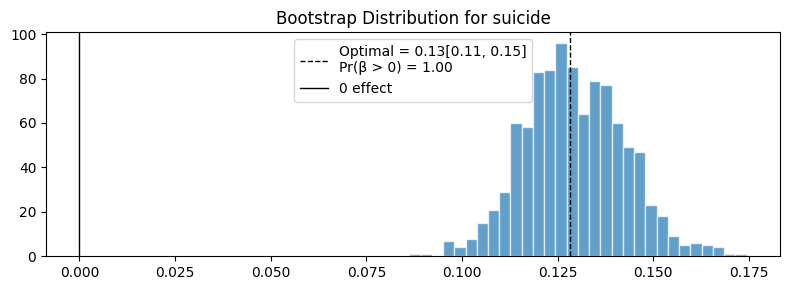

In [295]:
# As an example, plot the bootstrap distribution for the 'suicide' coefficient.
# This visualisation shows the spread of bootstrap estimates and the calculated statistics.
plot_bootstrap(
    selected_vars = ['suicide'],  # Specify the variable to plot by name.
    beta_names = beta_names,
    bootstrap_coefs = bootstrap_coefs
)

#### Part 2): Ridge Regression v. Linear Regression for Prediction

In [296]:
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
import statsmodels.api as sm
from scipy.stats import spearmanr

In [297]:
# Prepare dataset -- 
# here I use a slightly bigger subsample as I don't have to plot coefficients etc. 
# and it might make for a more interesting prediction test

# Remove rows that contain any missing values.
YX_nona = YX.dropna()

# For simplicity and speed, take a random subsample of 1000 observations.
YX_nona = YX_nona.sample(n=1000, random_state=42)

# Zero variance columns (constant columns) do not provide useful information in regression.
variances = YX_nona.var(axis=0)  # Calculate variance for each column.
kept_columns = (variances != 0)   # Create a mask that is True for columns with non-zero variance.

# Keep only the columns with non-zero variance.
YX_nona_variable = YX_nona.loc[:, kept_columns]

# Update our feature list to include only those columns that were kept.
X_cols = [col for col in X_cols if kept_columns.get(col, False)]

# Split Data into Features (X) and Response (Y)
X = YX_nona_variable[X_cols]
Y = YX_nona_variable[Y_cols]

# To help with normality, transform the response by taking the log.
# Adding 1 ensures that we do not take the log of 0.
log_Y = np.log(Y + 1)

# Standardisation (z-scoring) centers the data and scales it to unit variance,
# which is important when using regularization (like Ridge regression).
X_scaled = scaler.fit_transform(X)

In [298]:
# We split the (standardised) design matrix, the log-response, the original Y,
# and also preserve the indices (from the sampled dataset) so we can later retrieve the year.
X_train, X_test, log_Y_train, log_Y_test, idx_train, idx_test = train_test_split(
    X_scaled, log_Y, YX_nona_variable.index, test_size=0.3, random_state=42
)

In [299]:
# TODO 7: Constant to training / test set
# Add a constant to the training / test datasets using statsmodels.api (sm) imported above.
# Hint: Use sm.OLS() and don't forget to add a constant to the training

# 1. Linear Regression fit and out-of-sample predictions

# Add a constant (intercept) to both training and test sets.
X_train_const = sm.add_constant(X_train)
X_test_const  = sm.add_constant(X_test)

# TODO 8: OLS Model Fitting
# Fit an Ordinary Least Squares (OLS) model using statsmodels
# Hint: Use sm.OLS() and use the training set where you added a constant.
ols_model = sm.OLS(log_Y_train, X_train_const).fit()


In [300]:
# TODO 9: OLS Prediction Intervals
# Generate predictions and prediction intervals for the test set with constant
# Hint: Use get_prediction() and summary_frame()
predictions = ols_model.get_prediction(X_test_const)
pred_summary = predictions.summary_frame(alpha=0.05)  # 95% prediction intervals

# Hint: Extract predicted log-values and the lower/upper bounds of the prediction intervals from pred_summary
lr_pred_log           = pred_summary['mean'].values
lr_pred_int_lower_log = pred_summary['obs_ci_lower'].values
lr_pred_int_upper_log = pred_summary['obs_ci_upper'].values

/Users/yuchia/anaconda3/lib/python3.11/site-packages/statsmodels/regression/_prediction.py:57: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(self.var_pred_mean + self.var_resid)
/Users/yuchia/anaconda3/lib/python3.11/site-packages/statsmodels/regression/_prediction.py:76: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(self.var_pred_mean)


In [301]:
# 2. Ridge Regression with Bootstrap Prediction Intervals

# TODO 10: Fit Ridge Model and make predictions
# Similar to TODO 2, create and fit a Ridge regression model with the optimal alpha previously found there and fit_intercept=True
# Hint: Use X_train and log_Y_train as your datasets
# Hint: Make predictions using X_test and save them into ridge_pred_log

# Fit the ridge regression model on the training data using the optimal alpha.
ridge_model2 = Ridge(alpha=optimal_alpha, fit_intercept=True)
ridge_model2.fit(X_train, log_Y_train)
ridge_pred_log = ridge_model2.predict(X_test)

In [302]:
# Estimate prediction intervals for ridge via bootstrap.
n_bootstraps = 1000
ridge_preds_boot = np.zeros((n_bootstraps, len(X_test)))  # to store predictions for each bootstrap

# TODO 11: Implement the bootstrap loop for ridge regression prediction intervals
# Hint: The implementation is very similar to TODO 3
# Hint: Resample indices, fit ridge model on bootstrap sample, store predictions

#. Your solution here ...
for i in range(n_bootstraps):
    # Resample indices from the training set (using integer positions)
    bootstrap_indices = resample(np.arange(len(X_train)), replace=True)
    
    # Use .iloc to index the pandas DataFrame/Series if necessary.
    X_train_boot = X_train.iloc[bootstrap_indices] if hasattr(X_train, 'iloc') else X_train[bootstrap_indices]
    log_Y_train_boot = log_Y_train.iloc[bootstrap_indices] if hasattr(log_Y_train, 'iloc') else log_Y_train[bootstrap_indices]
    
    # Fit a ridge model on the bootstrap sample.
    ridge_boot = Ridge(alpha=optimal_alpha, fit_intercept=True)
    ridge_boot.fit(X_train_boot, log_Y_train_boot)
    
    # Predict on the test set and convert the output to a 1D array.
    ridge_preds_boot[i, :] = ridge_boot.predict(X_test).ravel()


# For each test observation, compute the 2.5th and 97.5th percentiles of the bootstrap predictions.
ridge_pred_int_lower_log = np.percentile(ridge_preds_boot, 2.5, axis=0)
ridge_pred_int_upper_log = np.percentile(ridge_preds_boot, 97.5, axis=0)

In [303]:
# 3. Compute Performance Metrics (on the original scale)

# Convert Y_test_orig (which might be a DataFrame/Series) to a flat NumPy array.
log_Y_test_arr = log_Y_test.values.flatten() 

# TODO 12: Calculate Performance Metrics ====
# Compute evaluation metrics for both models
# Hint: Use np.mean() and np.sqrt() for RMSE, spearmanr() for correlation

# For Linear Regression:
lr_bias     = np.mean(lr_pred_log - log_Y_test_arr)
lr_rmse     = np.sqrt(np.mean((lr_pred_log - log_Y_test_arr)**2))
lr_spearman = spearmanr(log_Y_test_arr, lr_pred_log).correlation
lr_coverage = np.mean((log_Y_test_arr >= lr_pred_int_lower_log) & (log_Y_test_arr <= lr_pred_int_upper_log))

# For Ridge Regression:
ridge_bias     = np.mean(ridge_pred_log - log_Y_test_arr)
ridge_rmse     = np.sqrt(np.mean((ridge_pred_log - log_Y_test_arr) ** 2))
ridge_spearman = spearmanr(log_Y_test_arr, ridge_pred_log).correlation
ridge_coverage = np.mean((log_Y_test_arr >= ridge_pred_int_lower_log) & (log_Y_test_arr <= ridge_pred_int_upper_log))

# Create legend labels that include the metrics.
lr_label = (f"Linear Regression\nBias: {lr_bias:.2f}, RMSE: {lr_rmse:.2f}\n"
            f"Spearman: {lr_spearman:.2f}, Coverage: {lr_coverage*100:.1f}%")
ridge_label = (f"Ridge Regression\nBias: {ridge_bias:.2f}, RMSE: {ridge_rmse:.2f}\n"
               f"Spearman: {ridge_spearman:.2f}, Coverage: {ridge_coverage*100:.1f}%")

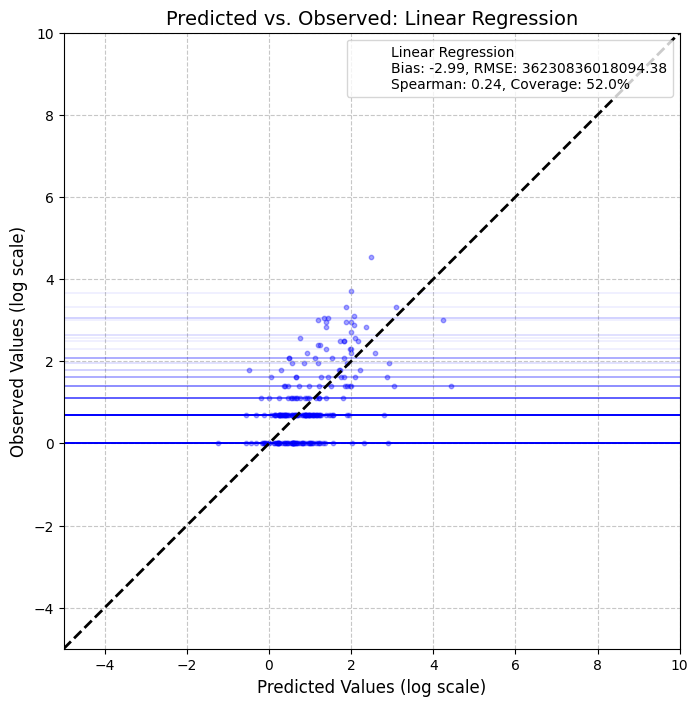

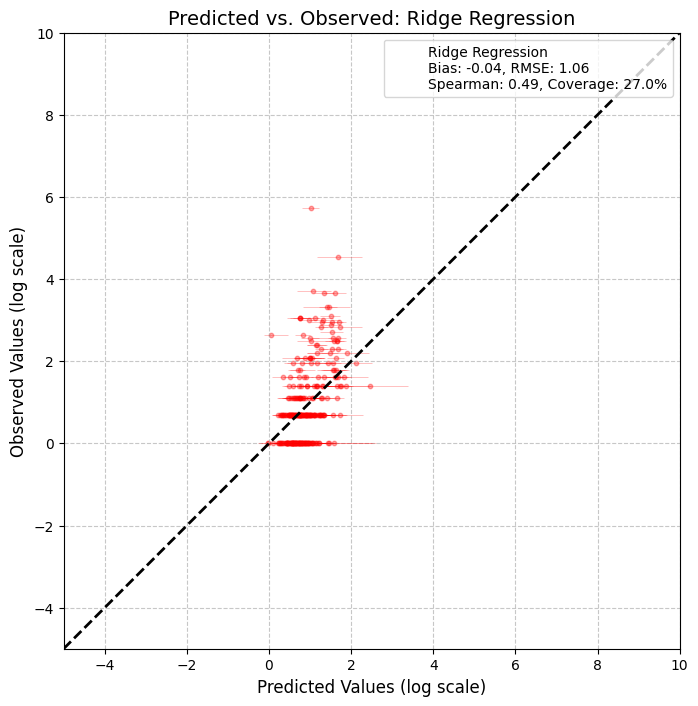

In [304]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch


lr_pred_log           = np.array(lr_pred_log).flatten()
lr_pred_int_lower_log = np.array(lr_pred_int_lower_log).flatten()
lr_pred_int_upper_log = np.array(lr_pred_int_upper_log).flatten()
ridge_pred_log           = np.array(ridge_pred_log).flatten()
ridge_pred_int_lower_log = np.array(ridge_pred_int_lower_log).flatten()
ridge_pred_int_upper_log = np.array(ridge_pred_int_upper_log).flatten()
log_Y_test_arr       = np.array(log_Y_test_arr).flatten()



# Determine overall min and max values for consistency
min_val = -5
max_val = 10

# ----------------------------
# Plot for Linear Regression
# ----------------------------

plt.figure(figsize=(8, 8))

# Scatter plot of predicted vs. observed (log scale)
plt.scatter(lr_pred_log, log_Y_test_arr, color='blue', s=10, alpha=0.35)

# Plot horizontal error bars for the 95% prediction intervals.
# Compute the error lengths on the left and right.
lr_err_left  = lr_pred_log - lr_pred_int_lower_log
lr_err_right = lr_pred_int_upper_log - lr_pred_log
plt.errorbar(lr_pred_log, log_Y_test_arr,
             xerr=[lr_err_left, lr_err_right],
             fmt='none', ecolor='blue', lw=0.25, alpha=0.35)

# Plot a 45-degree reference line
plt.plot([min_val, max_val], [min_val, max_val], 'k--', lw=2)

# Set consistent x and y limits and enforce an equal aspect ratio
plt.xlim(min_val, max_val)
plt.ylim(min_val, max_val)
plt.gca().set_aspect('equal', adjustable='box')

# Label axes and title
plt.xlabel("Predicted Values (log scale)", fontsize=12)
plt.ylabel("Observed Values (log scale)", fontsize=12)
plt.title("Predicted vs. Observed: Linear Regression", fontsize=14)

# Create a custom legend entry using a transparent Patch that displays the performance metrics.
lr_legend_handle = Patch(color='none', label=lr_label)
plt.legend(handles=[lr_legend_handle], loc='upper right', frameon=True)

plt.grid(True, linestyle='--', alpha=0.7)
plt.show(block=False)

# ----------------------------
# Plot for Ridge Regression
# ----------------------------

plt.figure(figsize=(8, 8))

# Scatter plot of predicted vs. observed (log scale)
plt.scatter(ridge_pred_log, log_Y_test_arr, color='red', s=10, alpha=0.35)

# Plot horizontal error bars for the 95% prediction intervals.
ridge_err_left  = ridge_pred_log - ridge_pred_int_lower_log
ridge_err_right = ridge_pred_int_upper_log - ridge_pred_log
plt.errorbar(ridge_pred_log, log_Y_test_arr,
             xerr=[ridge_err_left, ridge_err_right],
             fmt='none', ecolor='red', lw=0.5, alpha=0.35)

# Plot a 45-degree reference line
plt.plot([min_val, max_val], [min_val, max_val], 'k--', lw=2)

# Set consistent x and y limits and enforce an equal aspect ratio
plt.xlim(min_val, max_val)
plt.ylim(min_val, max_val)
plt.gca().set_aspect('equal', adjustable='box')

# Label axes and title
plt.xlabel("Predicted Values (log scale)", fontsize=12)
plt.ylabel("Observed Values (log scale)", fontsize=12)
plt.title("Predicted vs. Observed: Ridge Regression", fontsize=14)

# Create a custom legend entry for the ridge performance metrics.
ridge_legend_handle = Patch(color='none', label=ridge_label)
plt.legend(handles=[ridge_legend_handle], loc='upper right', frameon=True)

plt.grid(True, linestyle='--', alpha=0.7)
plt.show(block=False)


Questions: 
1) why are the predictions from the Linear Regression model so poorly behaved? how can we tell that something fundamental has gone away?

- Note that for Linear Regression we obtained a very large RMSE, which indicates severe numerical instability. This can be linked to the multicollinearity in the dataset. As you have already learnt during the lecture, when features are highly correlated, the matrix operations become unstable during coefficient estimation and leads to such problems (i.e., the matrix X^T * X is non-invertible and the coefficients can have high variance making them unreliable).

- Also, the large negative bias (-2.98) also suggests the model is making systematically underestimated predictions.


2) What can we say about the point estimates of the ridge regression, when comparing to the linear regression? what feature of ridge regression is clearly visible? You can name more than one.

- Ridge regression has much better numerical stability, since RMSE has a relatively normal value of 1.02. At the same time, the bias is much closer to 0 (-0.04 vs -2.98), showing better calibrated predictions. This demonstrates Ridge regression's key feature of coefficient shrinkage through L2 regularization.

- The regularization helps prevent the coefficient explosion we saw in linear regression because X^T * X + \alpha * I is always invertible, even though X^T * X is not!

3) Which model is best performing and why? describe the meaning of each performance metric.

- Bias: Measures the average difference between predictions and actual values

    Ridge: -0.04 (very close to ideal value of 0)

    Linear: -2.98 (shows systematic underprediction)


- RMSE (Root Mean Square Error): Measures the standard deviation of prediction errors

    Ridge: 1.02 (reasonable scale)

    Linear: 36230836018094.41 (EXTREMELY large)


- Spearman Correlation: Measures how well the predicted rankings match actual rankings

    Ridge: 0.49 (moderate positive correlation)

    Linear: 0.25 (weak positive correlation)

- Coverage: Percentage of true values falling within the model's prediction intervals

    Ridge: 23.7% (lower than ideal 95% coverage suggests overconfident predictions)

    Linear: 58.0% (better coverage but meaningless given the other metrics)


Ridge Regression performs better because it successfully handles the numerical instability brought by the simple Linear Regression model. Its regularization prevents coefficient explosion with high variance while maintaining good predictive power.

# SUMMATIVE ASSESSMENT

Now pick a dataset of your choice. Please ensure your dataset is a csv file under 100MB named sem4_portfolio_1_data_custom.csv

You should choose a dataset for which you have no prior knowledge of the underlying data generating process (i.e. if you're an expert in election, do not pick an elections dataset -- aim to learn something totally new). Ensure the dataset is moderately sized, but has a very large number of features, such that multicollinearity is likely present and regularisation is necessary.  

Using BOTH model regularisation and model selection (Hint: Lasso regression), show how penalised regression models can be used to learn about the distribution of the effect of useful features , and generate accurate predictions for the target of interest. 

In [305]:
# Do NOT modify the contents of this cell. Start your customization in the next one!
custom_data_path = "sem4_portfolio_1_data_custom.csv"
custom_df = pd.read_csv(custom_data_path)

The Garment Industry is one of the key examples of the industrial globalization of this modern era. It is a highly labour-intensive industry with lots of manual processes. Satisfying the huge global demand for garment products is mostly dependent on the production and delivery performance of the employees in the garment manufacturing companies. So, it is highly desirable among the decision makers in the garments industry to track, analyse and predict the productivity performance of the working teams in their factories.<br>

This dataset includes important attributes of the garment manufacturing process and the productivity of the employees which had been collected manually and also been validated by the industry experts.

# In this assignment, we are going to make predictions for the productivity in the garment factory.

In [306]:
# To see the structure of the custom dataset, we can print the first few rows.
print(custom_df.head())

       date   quarter  department       day  team  targeted_productivity     smv       wip  over_time  incentive  idle_time  idle_men  no_of_style_change  no_of_workers  actual_productivity
0  1/1/2015  Quarter1      sweing  Thursday     8                 0.8000 26.1600 1108.0000       7080         98     0.0000         0                   0        59.0000               0.9407
1  1/1/2015  Quarter1  finishing   Thursday     1                 0.7500  3.9400       NaN        960          0     0.0000         0                   0         8.0000               0.8865
2  1/1/2015  Quarter1      sweing  Thursday    11                 0.8000 11.4100  968.0000       3660         50     0.0000         0                   0        30.5000               0.8006
3  1/1/2015  Quarter1      sweing  Thursday    12                 0.8000 11.4100  968.0000       3660         50     0.0000         0                   0        30.5000               0.8006
4  1/1/2015  Quarter1      sweing  Thursday     6 

In [307]:
custom_df

,date,quarter,department,day,team,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity
0,1/1/2015,Quarter1,sweing,Thursday,8,0.8000,26.1600,1108.0000,7080,98,0.0000,0,0,59.0000,0.9407
1,1/1/2015,Quarter1,finishing,Thursday,1,0.7500,3.9400,NaN,960,0,0.0000,0,0,8.0000,0.8865
2,1/1/2015,Quarter1,sweing,Thursday,11,0.8000,11.4100,968.0000,3660,50,0.0000,0,0,30.5000,0.8006
3,1/1/2015,Quarter1,sweing,Thursday,12,0.8000,11.4100,968.0000,3660,50,0.0000,0,0,30.5000,0.8006
4,1/1/2015,Quarter1,sweing,Thursday,6,0.8000,25.9000,1170.0000,1920,50,0.0000,0,0,56.0000,0.8004
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1192,3/11/2015,Quarter2,finishing,Wednesday,10,0.7500,2.9000,NaN,960,0,0.0000,0,0,8.0000,0.6283
1193,3/11/2015,Quarter2,finishing,Wednesday,8,0.7000,3.9000,NaN,960,0,0.0000,0,0,8.0000,0.6256
1194,3/11/2015,Quarter2,finishing,Wednesday,7,0.6500,3.9000,NaN,960,0,0.0000,0,0,8.0000,0.6256
1195,3/11/2015,Quarter2,finishing,Wednesday,9,0.7500,2.9000,NaN,1800,0,0.0000,0,0,15.0000,0.5059


In [308]:
# 1. Convert the 'date' column to datetime objects so we can work with dates.
custom_df['date'] = pd.to_datetime(custom_df['date'], errors='coerce')

# 2. Extract the year from the 'date' column and store it in a new column called 'year'.
custom_df['year'] = custom_df['date'].dt.year

# 3. Convert the 'year' column to a categorical variable. 
# This is useful if you want to treat the year as a factor rather than a continuous variable.
custom_df['year'] = custom_df['year'].astype('category')

In [309]:
# Convert several categorical columns into dummy/indicator variables (one-hot encoding).
cat_cols = ['year', 'quarter', 'department', 'day', 'team']
custom_df_dummies = pd.get_dummies(custom_df, columns=cat_cols, drop_first=False)

In [310]:
custom_df_dummies

,date,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity,year_2015,quarter_Quarter1,quarter_Quarter2,quarter_Quarter3,quarter_Quarter4,quarter_Quarter5,department_finishing,department_finishing,department_sweing,day_Monday,day_Saturday,day_Sunday,day_Thursday,day_Tuesday,day_Wednesday,team_1,team_2,team_3,team_4,team_5,team_6,team_7,team_8,team_9,team_10,team_11,team_12
0,2015-01-01,0.8000,26.1600,1108.0000,7080,98,0.0000,0,0,59.0000,0.9407,True,True,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False
1,2015-01-01,0.7500,3.9400,NaN,960,0,0.0000,0,0,8.0000,0.8865,True,True,False,False,False,False,False,True,False,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False
2,2015-01-01,0.8000,11.4100,968.0000,3660,50,0.0000,0,0,30.5000,0.8006,True,True,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False
3,2015-01-01,0.8000,11.4100,968.0000,3660,50,0.0000,0,0,30.5000,0.8006,True,True,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True
4,2015-01-01,0.8000,25.9000,1170.0000,1920,50,0.0000,0,0,56.0000,0.8004,True,True,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1192,2015-03-11,0.7500,2.9000,NaN,960,0,0.0000,0,0,8.0000,0.6283,True,False,True,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False
1193,2015-03-11,0.7000,3.9000,NaN,960,0,0.0000,0,0,8.0000,0.6256,True,False,True,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False
1194,2015-03-11,0.6500,3.9000,NaN,960,0,0.0000,0,0,8.0000,0.6256,True,False,True,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False
1195,2015-03-11,0.7500,2.9000,NaN,1800,0,0.0000,0,0,15.0000,0.5059,True,False,True,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False


In [311]:
# These define which columns to use as features (X) and which as the response (Y).

# Combine all the features into one master list.
X_cols = [
            'targeted_productivity', 
            'smv', 
            'wip', 
            'over_time', 
            'incentive', 
            'idle_time', 
            'idle_men',
            'no_of_style_change',
            'no_of_workers',
            'quarter_Quarter1',
            'quarter_Quarter2',
            'quarter_Quarter3',
            'quarter_Quarter4',
            'quarter_Quarter5',
            'department_finishing',
            'department_finishing ',
            'department_sweing',
            'day_Monday',
            'day_Saturday',
            'day_Sunday',
            'day_Thursday',
            'day_Tuesday',
            'day_Wednesday',
            'team_1',
            'team_2',
            'team_3',
            'team_4',
            'team_5',
            'team_6',
            'team_7',
            'team_8',
            'team_9',
            'team_10',
            'team_11',
            'team_12'
          ]

# The outcome (response) variable is 'Energy Consumption'.
Y_cols = ['actual_productivity']

# Create a combined list of columns that includes the response and the features.
YX_cols = Y_cols + X_cols

# Subset the dataframe to include only these columns.
YX = custom_df_dummies[YX_cols]
YX['actual_productivity'] = YX['actual_productivity'] * 100 # In order to calculate we take its percentage here

# Remove rows that contain any missing values.
YX_nona = YX.dropna()

# For simplicity and speed, take a random subsample of 600 observations.
YX_nona = YX_nona.sample(n=600, random_state=42)

/var/folders/2g/xfsvxxmd2158x4mn_qg2ycpr0000gn/T/ipykernel_37315/2988870313.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  YX['actual_productivity'] = YX['actual_productivity'] * 100 # In order to calculate we take its percentage here


In [312]:
# Zero variance columns (constant columns) do not provide useful information in regression.
variances = YX_nona.var(axis=0)  # Calculate variance for each column.
kept_columns = (variances != 0)   # Create a mask that is True for columns with non-zero variance.

# Keep only the columns with non-zero variance.
YX_nona_variable = YX_nona.loc[:, kept_columns]

# Update our feature list to include only those columns that were kept.
X_cols = [col for col in X_cols if kept_columns.get(col, False)]

In [313]:
# Split Data into Features (X) and Response (Y)
X = YX_nona_variable[X_cols]
Y = YX_nona_variable[Y_cols]

# To help with normality, transform the response by taking the percentage.
# Adding 1 ensures that we do not take the log of 0.
log_Y = np.log(Y + 1)

In [314]:
# Standardisation (z-scoring) centers the data and scales it to unit variance
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

## Part_1: Model Regularisation:

Here we are going to prepare the performance of different models, and select the best one.

In [315]:
# Lasso regression is used to prevent overfitting when predictors are highly correlated.
# It adds a penalty (alpha) to the size of the coefficients.
from sklearn.linear_model import Lasso, LassoCV
from sklearn.utils import resample

# Use cross-validation to choose the optimal regularization parameter (alpha).
# We test a wide range of candidate alpha values on a logarithmic scale.
alphas = np.logspace(-5, 5, 600)

# LassoCV Setup
# Create a LassoCV model with specified alphas, fit_intercept=True, and negative MSE scoring
lasso_cv = LassoCV(alphas=alphas, cv=10, random_state=42).fit(X_scaled, log_Y)

optimal_alpha = lasso_cv.alpha_  # Optimal alpha determined by cross-validation.
print(f"Optimal alpha found via cross-validation: {optimal_alpha:.4f}")

/Users/yuchia/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:1623: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Optimal alpha found via cross-validation: 0.0114


In [316]:
# Create and fit a Ridge regression model with the optimal alpha previously found and fit_intercept=True
lasso_model = Lasso(alpha=optimal_alpha, fit_intercept=True).fit(X_scaled, log_Y)

# Combine the intercept and coefficients into one array for later reference.
beta_hat = np.concatenate((lasso_model.intercept_.ravel(), lasso_model.coef_.ravel()))

# Create a list of names for the coefficients, starting with the intercept.
beta_names = ['(intercept)'] + X_cols

In [317]:
# Bootstrap resampling helps us estimate the uncertainty (variability) of our coefficients.
# I repeatedly resample the data and refit the model to obtain a distribution of coefficient estimates.
n_bootstraps = 1000  # Number of bootstrap samples.
# Initialize an array to store coefficients from each bootstrap iteration.
bootstrap_coefs = np.zeros((n_bootstraps, len(X_cols) + 1))  # +1 for the intercept.

# Bootstrap Implementation
# Implement the bootstrap resampling loop
from sklearn.utils import resample

for i in range(n_bootstraps):
    X_resampled, log_Y_resampled = resample(X_scaled, log_Y, random_state=i)
    lasso_boot = Lasso(alpha=optimal_alpha, fit_intercept=True).fit(X_resampled, log_Y_resampled)
    bootstrap_coefs[i, :] = np.concatenate(([lasso_boot.intercept_.flatten()[0]], lasso_boot.coef_.ravel()))



In [318]:
# Calculate the standard errors of the coefficients from the bootstrap samples.
bootstrap_std_errors = np.std(bootstrap_coefs, axis=0)

# Calculate the 95% confidence intervals (using the 2.5th and 97.5th percentiles), and the median value.
ci_lower = np.percentile(bootstrap_coefs, 2.5, axis=0)
ci_upper = np.percentile(bootstrap_coefs, 97.5, axis=0)
median   = np.percentile(bootstrap_coefs, 50, axis=0)

# Compute the probability that each coefficient is greater than 0.
# This is the proportion of bootstrap samples for which the coefficient is positive.
prob_positive = np.mean(bootstrap_coefs > 0, axis=0)

# Create a summary DataFrame with the bootstrap results.
summary_df = pd.DataFrame({
    "Coefficient": beta_names,
    "Median": median,
    "95% CI Lower": ci_lower,
    "95% CI Upper": ci_upper,
    "Bootstrap Std Error": bootstrap_std_errors,
    "Pr(>0)": prob_positive
})

print("\nSummary Table:")
print(summary_df.to_string(index=False))


Summary Table:
          Coefficient  Median  95% CI Lower  95% CI Upper  Bootstrap Std Error  Pr(>0)
          (intercept)  4.2671        4.2568        4.2773               0.0052  1.0000
targeted_productivity  0.1000        0.0781        0.1178               0.0104  1.0000
                  smv -0.0118       -0.0291        0.0000               0.0080  0.0000
                  wip  0.0000        0.0000        0.0000               0.0000  0.0000
            over_time -0.0000       -0.0058        0.0000               0.0015  0.0000
            incentive  0.1190        0.1017        0.1376               0.0094  1.0000
            idle_time  0.0000       -0.0002        0.0204               0.0054  0.2490
             idle_men -0.0306       -0.0551        0.0000               0.0137  0.0000
   no_of_style_change  0.0000        0.0000        0.0080               0.0022  0.1950
        no_of_workers  0.0000        0.0000        0.0034               0.0013  0.0630
     quarter_Quarter1  0.00

We now design a function to plot bootstrap distribution.

In [319]:
# Function to Plot Bootstrap Distribution
def plot_bootstrap(bootstrap_coefs, beta_names=None, selected_vars=None, point_est='median'):
 
    # Determine the total number of parameters.
    n_params = bootstrap_coefs.shape[1]
    # Create default parameter names if none are provided.
    if beta_names is None:
        beta_names = [f"Param{i}" for i in range(n_params)]

    # Plotting Function Implementation
    
    # Compute the point estimate based on the user's choice (mean or median).
    if point_est == 'mean':
        est = np.mean(bootstrap_coefs, axis=0)
    elif point_est == 'median':
        est = np.median(bootstrap_coefs, axis=0)
    else:
        raise ValueError("point_est must be either 'mean' or 'median'")
    
    # Calculate the 95% confidence intervals and the probability that coefficients are > 0.
    ci_lower = np.percentile(bootstrap_coefs, 2.5, axis=0)
    ci_upper = np.percentile(bootstrap_coefs, 97.5, axis=0)
    prob_positive = np.mean(bootstrap_coefs > 0, axis=0)
    
    # Determine which parameters to plot.
    if selected_vars is None:
        indices = range(n_params)
    else:
        # If the user provided indices.
        if all(isinstance(x, int) for x in selected_vars):
            indices = selected_vars
        # If the user provided names.
        elif all(isinstance(x, str) for x in selected_vars):
            indices = []
            for var in selected_vars:
                if var in beta_names:
                    indices.append(beta_names.index(var))
                else:
                    print(f"Warning: {var} not found in beta_names.")
        else:
            raise ValueError("selected_vars must be a list of either ints or strs.")
    
    # Create subplots: one for each selected parameter.
    n_plots = len(indices)
    fig, axes = plt.subplots(n_plots, 1, figsize=(8, 3 * n_plots))
    # Ensure that axes is always a list (even if there's only one plot).
    if n_plots == 1:
        axes = [axes]
    
    # Loop over each selected parameter to create its histogram.
    for ax, idx in zip(axes, indices):
        # Plot histogram of the bootstrap coefficients for parameter idx.
        ax.hist(bootstrap_coefs[:, idx], bins=30, edgecolor='white', alpha=0.7)
        # Draw a dashed line at the point estimate (with CI info in the legend).
        ax.axvline(est[idx], color='black', linestyle='dashed', linewidth=1,
                   label=(f'Optimal = {est[idx]:.2f}[{ci_lower[idx]:.2f}, {ci_upper[idx]:.2f}]\n'
                          f'Pr(β > 0) = {prob_positive[idx]:.2f}'))
        # Draw a solid blue line at zero.
        ax.axvline(0, color='black', linestyle='solid', linewidth=1, label='0 effect')
        ax.set_title(f'Bootstrap Distribution for {beta_names[idx]}')
        ax.legend()
    
    plt.tight_layout()
    plt.show(block=False)

In [320]:
# Significant Coefficients
# Identify significant coefficients using bootstrap probabilities
# Consider "significant" if Pr(>0) <= 0.1 or >= 0.9
sig_idx = np.where((prob_positive <= 0.1) | (prob_positive >= 0.9))[0]
sig_names = [beta_names[i] for i in sig_idx]

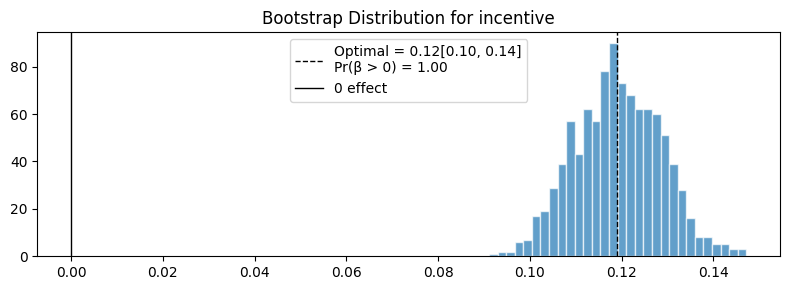

In [321]:
# As an example, plot the bootstrap distribution for the 'incentive' coefficient.
# This visualisation shows the spread of bootstrap estimates and the calculated statistics.
plot_bootstrap(
    selected_vars = ['incentive'],  # Specify the variable to plot by name.
    beta_names = beta_names,
    bootstrap_coefs = bootstrap_coefs
)

## Part_2: Model Selection

Here we compare the Lasso Model with the Linear Regression Model and select one of them based on their performance.

In [322]:
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
import statsmodels.api as sm
from scipy.stats import spearmanr

In [323]:
# Prepare dataset -- 
# here I use a slightly bigger subsample as I don't have to plot coefficients etc. 
# and it might make for a more interesting prediction test

# Remove rows that contain any missing values.
YX_nona = YX.dropna()

# For simplicity and speed, take a random subsample of 1000 observations.
YX_nona = YX_nona.sample(n=500, random_state=42)

# Zero variance columns (constant columns) do not provide useful information in regression.
variances = YX_nona.var(axis=0)  # Calculate variance for each column.
kept_columns = (variances != 0)   # Create a mask that is True for columns with non-zero variance.

# Keep only the columns with non-zero variance.
YX_nona_variable = YX_nona.loc[:, kept_columns]

# Update our feature list to include only those columns that were kept.
X_cols = [col for col in X_cols if kept_columns.get(col, False)]

# Split Data into Features (X) and Response (Y)
X = YX_nona_variable[X_cols]
Y = YX_nona_variable[Y_cols]

# To help with normality, transform the response by taking the log.
# Adding 1 ensures that we do not take the log of 0.
log_Y = np.log(Y + 1)

# Standardisation (z-scoring) centers the data and scales it to unit variance,
X_scaled = scaler.fit_transform(X)

In [324]:
# We split the (standardised) design matrix, the log-response, the original Y,
# and also preserve the indices (from the sampled dataset) so we can later retrieve the year.
X_train, X_test, log_Y_train, log_Y_test, idx_train, idx_test = train_test_split(
    X_scaled, log_Y, YX_nona_variable.index, test_size=0.3, random_state=42
)

Linear Regression

In [325]:
# Constant to training / test set
# Add a constant to the training / test datasets using statsmodels.api (sm) imported above.

# 1. Linear Regression fit and out-of-sample predictions

# Add a constant (intercept) to both training and test sets.
X_train_const = sm.add_constant(X_train)
X_test_const  = sm.add_constant(X_test)

# OLS Model Fitting
# Fit an Ordinary Least Squares (OLS) model using statsmodels
ols_model = sm.OLS(log_Y_train, X_train_const).fit()

In [326]:
# OLS Prediction Intervals
# Generate predictions and prediction intervals for the test set with constant
predictions = ols_model.get_prediction(X_test_const)
pred_summary = predictions.summary_frame(alpha=0.05)  # 95% prediction intervals

# Extract predicted log-values and the lower/upper bounds of the prediction intervals from pred_summary
lr_pred_log = pred_summary['mean'].values
lr_pred_int_lower_log = pred_summary['obs_ci_lower'].values
lr_pred_int_upper_log = pred_summary['obs_ci_upper'].values

Lasso Regression

In [327]:
# 2. Lasso Regression with Bootstrap Prediction Intervals

# Fit Lasso Model and make predictions

# Fit the lasso regression model on the training data using the optimal alpha.
lasso_model2 = Lasso(alpha=optimal_alpha, fit_intercept=True).fit(X_train, log_Y_train)
lasso_pred_log = lasso_model2.predict(X_test)

In [328]:
# Estimate prediction intervals for lasso via bootstrap.
n_bootstraps = 1000
lasso_preds_boot = np.zeros((n_bootstraps, len(X_test)))  # to store predictions for each bootstrap

# Implement the bootstrap loop for lasso regression prediction intervals

for i in range(n_bootstraps):
    bootstrap_indices = resample(np.arange(len(X_train)), replace=True)
    
    # Use .iloc to index the pandas DataFrame/Series if necessary.
    X_train_boot = X_train.iloc[bootstrap_indices] if hasattr(X_train, 'iloc') else X_train[bootstrap_indices]
    log_Y_train_boot = log_Y_train.iloc[bootstrap_indices] if hasattr(log_Y_train, 'iloc') else log_Y_train[bootstrap_indices]
    
    # Fit a lasso model on the bootstrap sample.
    lasso_boot = Lasso(alpha=optimal_alpha, fit_intercept=True)
    lasso_boot.fit(X_train_boot, log_Y_train_boot)
    lasso_preds_boot[i, :] = lasso_boot.predict(X_test).ravel()

# For each test observation, compute the 2.5th and 97.5th percentiles of the bootstrap predictions.
lasso_pred_int_lower_log = np.percentile(lasso_preds_boot, 2.5, axis=0)
lasso_pred_int_upper_log = np.percentile(lasso_preds_boot, 97.5, axis=0)

In [329]:
# 3. Compute Performance Metrics

# Convert Y_test_orig (which might be a DataFrame/Series) to a flat NumPy array.
log_Y_test_arr = log_Y_test.values.flatten() 

# Calculate Performance Metrics ====
# Compute evaluation metrics for both models

# For Linear Regression:
lr_bias     = np.mean(lr_pred_log - log_Y_test_arr)
lr_rmse     = np.sqrt(np.mean((lr_pred_log - log_Y_test_arr)**2))
lr_spearman = spearmanr(log_Y_test_arr, lr_pred_log).correlation
lr_coverage = np.mean((log_Y_test_arr >= lr_pred_int_lower_log) & (log_Y_test_arr <= lr_pred_int_upper_log))

# For Lasso Regression:
lasso_bias     = np.mean(lasso_pred_log - log_Y_test_arr)
lasso_rmse     = np.sqrt(np.mean((lasso_pred_log - log_Y_test_arr) ** 2))
lasso_spearman = spearmanr(log_Y_test_arr, lasso_pred_log).correlation
lasso_coverage = np.mean((log_Y_test_arr >= lasso_pred_int_lower_log) & (log_Y_test_arr <= lasso_pred_int_upper_log))

# Create legend labels that include the metrics.
lr_label = (f"Linear Regression\nBias: {lr_bias:.5f}, RMSE: {lr_rmse:.5f}\n"
            f"Spearman: {lr_spearman:.2f}, Coverage: {lr_coverage*100:.1f}%")
lasso_label = (f"Lasso Regression\nBias: {lasso_bias:.5f}, RMSE: {lasso_rmse:.5f}\n"
               f"Spearman: {lasso_spearman:.2f}, Coverage: {lasso_coverage*100:.1f}%")

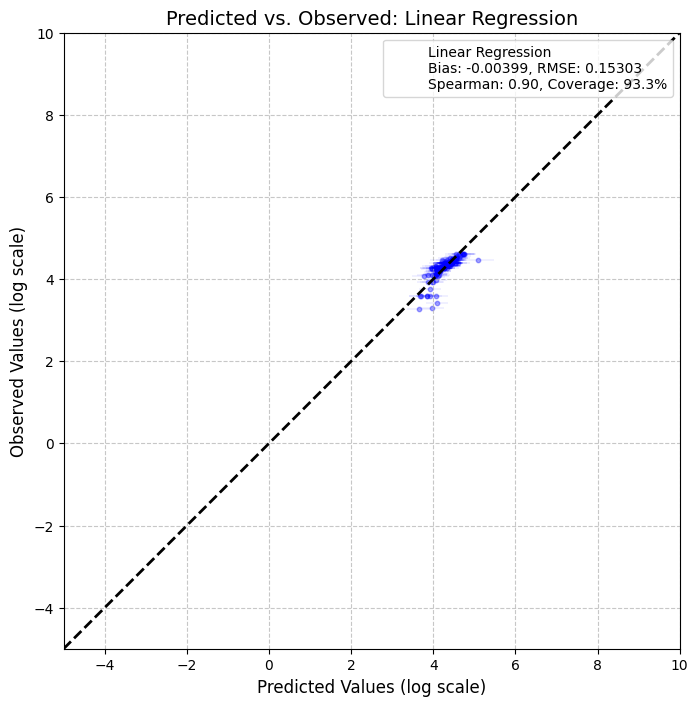

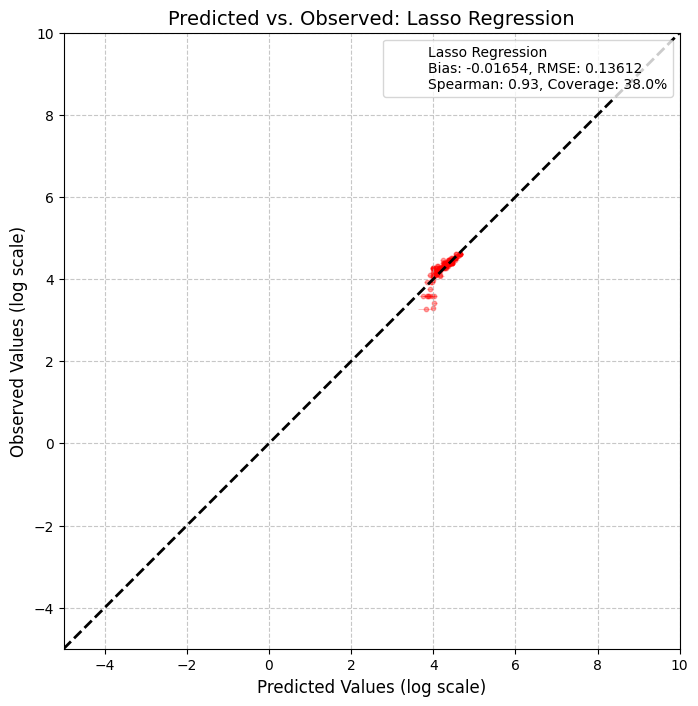

In [330]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch


lr_pred_log           = np.array(lr_pred_log).flatten()
lr_pred_int_lower_log = np.array(lr_pred_int_lower_log).flatten()
lr_pred_int_upper_log = np.array(lr_pred_int_upper_log).flatten()
lasso_pred_log           = np.array(lasso_pred_log).flatten()
lasso_pred_int_lower_log = np.array(lasso_pred_int_lower_log).flatten()
lasso_pred_int_upper_log = np.array(lasso_pred_int_upper_log).flatten()
log_Y_test_arr       = np.array(log_Y_test_arr).flatten()



# Determine overall min and max values for consistency
min_val = -5
max_val = 10

# ----------------------------
# Plot for Linear Regression
# ----------------------------

plt.figure(figsize=(8, 8))

# Scatter plot of predicted vs. observed (log scale)
plt.scatter(lr_pred_log, log_Y_test_arr, color='blue', s=10, alpha=0.35)

# Plot horizontal error bars for the 95% prediction intervals.
# Compute the error lengths on the left and right.
lr_err_left  = lr_pred_log - lr_pred_int_lower_log
lr_err_right = lr_pred_int_upper_log - lr_pred_log
plt.errorbar(lr_pred_log, log_Y_test_arr,
             xerr=[lr_err_left, lr_err_right],
             fmt='none', ecolor='blue', lw=0.25, alpha=0.35)

# Plot a 45-degree reference line
plt.plot([min_val, max_val], [min_val, max_val], 'k--', lw=2)

# Set consistent x and y limits and enforce an equal aspect ratio
plt.xlim(min_val, max_val)
plt.ylim(min_val, max_val)
plt.gca().set_aspect('equal', adjustable='box')

# Label axes and title
plt.xlabel("Predicted Values (log scale)", fontsize=12)
plt.ylabel("Observed Values (log scale)", fontsize=12)
plt.title("Predicted vs. Observed: Linear Regression", fontsize=14)

# Create a custom legend entry using a transparent Patch that displays the performance metrics.
lr_legend_handle = Patch(color='none', label=lr_label)
plt.legend(handles=[lr_legend_handle], loc='upper right', frameon=True)

plt.grid(True, linestyle='--', alpha=0.7)
plt.show(block=False)

# ----------------------------
# Plot for Lasso Regression
# ----------------------------

plt.figure(figsize=(8, 8))

# Scatter plot of predicted vs. observed (log scale)
plt.scatter(lasso_pred_log, log_Y_test_arr, color='red', s=10, alpha=0.35)

# Plot horizontal error bars for the 95% prediction intervals.
lasso_err_left  = lasso_pred_log - lasso_pred_int_lower_log
lasso_err_right = lasso_pred_int_upper_log - lasso_pred_log
plt.errorbar(lasso_pred_log, log_Y_test_arr,
             xerr=[lasso_err_left, lasso_err_right],
             fmt='none', ecolor='red', lw=0.5, alpha=0.35)

# Plot a 45-degree reference line
plt.plot([min_val, max_val], [min_val, max_val], 'k--', lw=2)

# Set consistent x and y limits and enforce an equal aspect ratio
plt.xlim(min_val, max_val)
plt.ylim(min_val, max_val)
plt.gca().set_aspect('equal', adjustable='box')

# Label axes and title
plt.xlabel("Predicted Values (log scale)", fontsize=12)
plt.ylabel("Observed Values (log scale)", fontsize=12)
plt.title("Predicted vs. Observed: Lasso Regression", fontsize=14)

# Create a custom legend entry for the ridge performance metrics.
lasso_legend_handle = Patch(color='none', label=lasso_label)
plt.legend(handles=[lasso_legend_handle], loc='upper right', frameon=True)

plt.grid(True, linestyle='--', alpha=0.7)
plt.show(block=False)


1. Bias<br>
Linear Regression: -0.00399 <br>
Lasso Regression: -0.01654 <br>
Comparison: Bias measures the average difference between predicted and observed values, with a negative value indicating underprediction. Linear Regression has a smaller bias (-0.00399) compared to Lasso Regression (-0.01654), meaning its predictions are, on average, closer to the true values. However, both biases are quite small in magnitude, so the practical difference here is minimal. Linear Regression has a slight edge in terms of bias, but this alone isn’t a dealbreaker for either model. <br>
2. RMSE (Root Mean Squared Error) <br>
Linear Regression: 0.15303 <br>
Lasso Regression: 0.13612 <br>
Comparison: RMSE quantifies the average magnitude of prediction errors, with lower values indicating better predictive accuracy. Lasso Regression outperforms Linear Regression here, with a lower RMSE of 0.13612 compared to 0.15303. This means that, on average, Lasso Regression’s predictions are closer to the observed values, making it more accurate in terms of raw prediction error. This is a clear advantage for Lasso Regression. <br>
3. Spearman Correlation <br>
Linear Regression: 0.90 <br>
Lasso Regression: 0.93 <br>
Comparison: The Spearman correlation measures the strength of the monotonic relationship between predicted and observed values, with values closer to 1 indicating a stronger relationship. Lasso Regression has a slightly higher Spearman correlation (0.93) compared to Linear Regression (0.90), suggesting it better captures the rank-order relationship between predicted and observed values. <br>
4. Coverage <br>
Linear Regression: 93.3% <br>
Lasso Regression: 38.0% <br>
Comparison: Coverage typically represents the percentage of observed values that fall within the model’s prediction intervals (e.g., 95% confidence intervals). A higher coverage indicates more reliable uncertainty estimates. Linear Regression significantly outperforms Lasso Regression in this metric, with a coverage of 93.3% compared to Lasso’s 38.7%. This is a substantial difference—Linear Regression’s prediction intervals are far more reliable, capturing over 93% of the observed values, while Lasso Regression’s low coverage suggests its intervals are too narrow, potentially due to overfitting or underestimating uncertainty. 